Mounting Drive to access the dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing the libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight

Load the dataset from the Google Drive

In [3]:
df = pd.read_csv('/content/drive/My Drive/ECG Project/Dataset/mitbih_train.csv', header=None)
df2 = pd.read_csv('/content/drive/My Drive/ECG Project/Dataset/mitbih_test.csv', header=None)
df = pd.concat([df, df2], axis=0)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Dataset Info : **

Arrhythmia Dataset

Number of Samples: 109446

Number of Categories: 5

Sampling Frequency: 125Hz

Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

-N : Non-ecotic beats (normal beat)

-S : Supraventricular ectopic beats

-V : Ventricular ectopic beats

-F : Fusion Beats

-Q : Unknown Beats

Samples on each classes

In [5]:
df[187]=df[187].astype(int)
df[187].value_counts()

0    90589
4     8039
2     7236
1     2779
3      803
Name: 187, dtype: int64

In [6]:
X=df.iloc[:,:-1]
y=df.iloc[:, -1].astype(int)

Splitting the Dataset into train and test values

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42,shuffle=True, stratify=y)

In [8]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (76612, 187)
y_train (76612,)
X_test (32834, 187)
y_test (32834,)


Applying the ADASYN Algorithm to handle imbalanced dataset

In [9]:
asy = ADASYN(random_state=42)
X_res, y_res = asy.fit_resample(X_train, y_train)

Shape of Train and Test values

In [10]:

X_train=np.array(X_res)
X_test=np.array(X_test)
y_train=np.array(y_res)
y_test=np.array(y_test)

In [11]:

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (317133, 187)
y_train (317133,)
X_test (32834, 187)
y_test (32834,)


Expanding the X_train and X_test Dimensions for model architecture to match

In [12]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

Converting the Targets into categorical form

In [13]:
from keras.utils.np_utils import to_categorical
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

After expanding the dimension of train and test values

In [14]:

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (317133, 187, 1)
y_train (317133, 5)
X_test (32834, 187, 1)
y_test (32834, 5)


Importing the Libraries for Neural Network

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model,model_from_json
from tensorflow.keras.layers import Input, Dense, Convolution1D, MaxPool1D,Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation , Dropout, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, EarlyStopping

Neural Network 1

In [16]:
n_obs, feature, depth = X_train.shape
batch_size = 500
K.clear_session()

inp = Input(shape=(feature, depth))
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)

C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S11)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 183, 32)      192         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 183, 32)      5152        ['conv1d[0][0]']                 
                                                                                                  
 activation (Activation)        (None, 183, 32)      0           ['conv1d_1[0][0]']               
                                                                                              

Training Phase

In [17]:
import math
batch_size = 512
def exp_decay(epoch):
    initial_lrate = 3e-5
    k = 0.75
    t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)
#checkpoint=ModelCheckpoint('model.h5',monitor='val_loss',mode='min',save_best_only=True)
adam = Adam(learning_rate = 3e-5, beta_1 = 0.9, beta_2 = 0.999)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=batch_size,
                    verbose=2,
                    validation_data=(X_test, y_test),
                    callbacks=[lrate])



Epoch 1/100
620/620 - 19s - loss: 1.2144 - accuracy: 0.5034 - val_loss: 1.0146 - val_accuracy: 0.5397 - lr: 3.0000e-05 - 19s/epoch - 30ms/step
Epoch 2/100
620/620 - 9s - loss: 0.8554 - accuracy: 0.6652 - val_loss: 0.7680 - val_accuracy: 0.7108 - lr: 3.0000e-05 - 9s/epoch - 15ms/step
Epoch 3/100
620/620 - 9s - loss: 0.6836 - accuracy: 0.7530 - val_loss: 0.7119 - val_accuracy: 0.7498 - lr: 3.0000e-05 - 9s/epoch - 14ms/step
Epoch 4/100
620/620 - 9s - loss: 0.5731 - accuracy: 0.8021 - val_loss: 0.6054 - val_accuracy: 0.7787 - lr: 3.0000e-05 - 9s/epoch - 14ms/step
Epoch 5/100
620/620 - 9s - loss: 0.4969 - accuracy: 0.8289 - val_loss: 0.5065 - val_accuracy: 0.8157 - lr: 3.0000e-05 - 9s/epoch - 15ms/step
Epoch 6/100
620/620 - 9s - loss: 0.4439 - accuracy: 0.8449 - val_loss: 0.4816 - val_accuracy: 0.8268 - lr: 3.0000e-05 - 9s/epoch - 15ms/step
Epoch 7/100
620/620 - 9s - loss: 0.4030 - accuracy: 0.8585 - val_loss: 0.4600 - val_accuracy: 0.8254 - lr: 3.0000e-05 - 9s/epoch - 14ms/step
Epoch 8/100

Calculating the metrics values towards test data


In [18]:
y_pred = model.predict(X_test, batch_size=1000)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print('Accuracy', accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
#print('ROC AUC score:', roc_auc_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print('confusion matrix:')
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

33/33 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     27177
           1       0.56      0.84      0.67       833
           2       0.90      0.95      0.92      2171
           3       0.70      0.77      0.73       241
           4       0.98      0.98      0.98      2412

    accuracy                           0.96     32834
   macro avg       0.83      0.90      0.86     32834
weighted avg       0.97      0.96      0.97     32834

Accuracy 0.9649448742157519
confusion matrix:
[[26372   521   179    58    47]
 [  121   698    10     1     3]
 [   78    15  2054    21     3]
 [   25     0    30   186     0]
 [   26     3    10     0  2373]]


<Axes: >

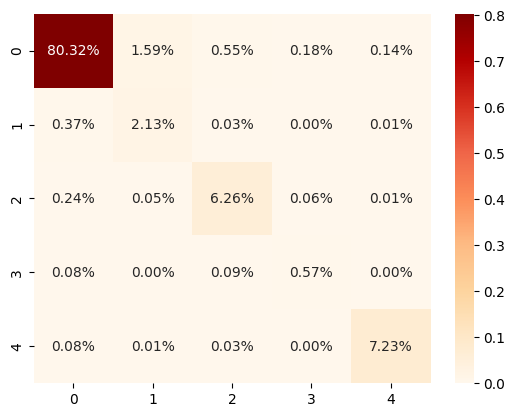

In [19]:
import seaborn as sns
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='OrRd')

 Visualisation

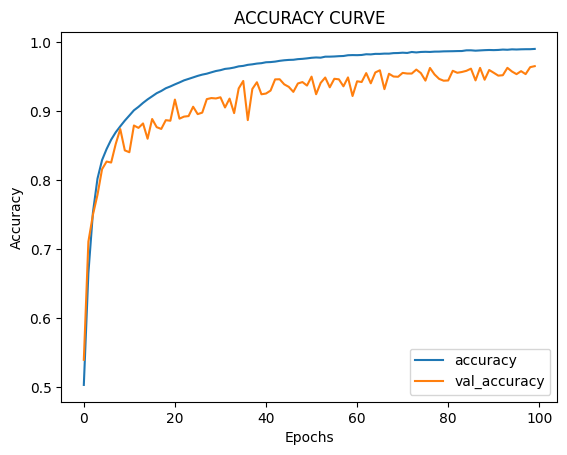

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ACCURACY CURVE')
plt.legend(['accuracy','val_accuracy'], loc='best')
plt.show()

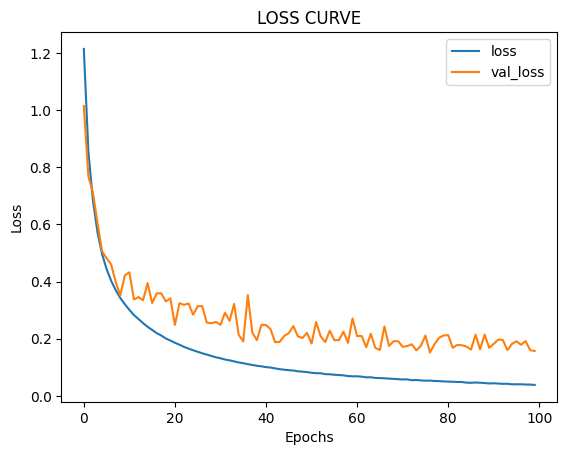

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LOSS CURVE')
plt.legend(['loss','val_loss'], loc='best')
plt.show()

Saving the trained model

In [22]:
model.save('/content/drive/My Drive/model.h5')
print('saved the model to disk')

saved the model to disk


Evaluating with extracted samples

In [23]:
test = pd.read_csv('/content/drive/My Drive/ECG Project/testdata.csv', header=None)
p=test.iloc[:,:]
p=np.expand_dims(p, 2)
test_pred = model.predict(p)

1/1 [==============================] - 0s 128ms/step


In [24]:
test

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.836,0.951,0.984,0.672,0.197,0.197,0.262,0.328,0.344,0.393,...,0,0,0,0,0,0,0,0,0,0
1,0.557,0.541,0.541,0.508,0.492,0.475,0.459,0.459,0.443,0.443,...,0,0,0,0,0,0,0,0,0,0


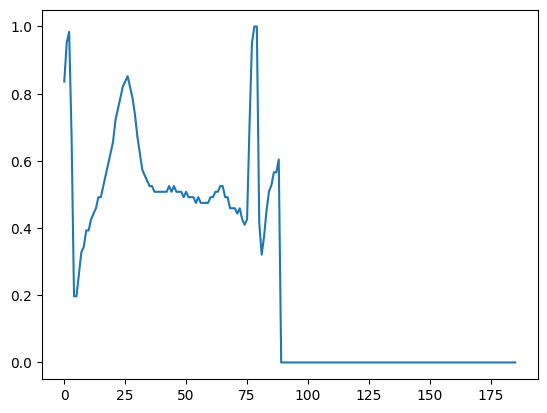

In [25]:
plt.plot(test.iloc[0,:186])

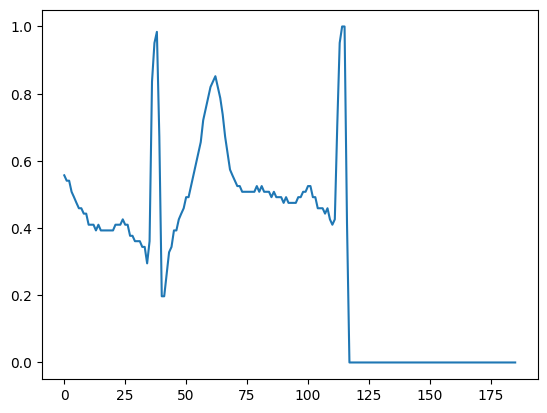

In [26]:
plt.plot(test.iloc[1,:186])

In [27]:
test_pred.argmax(axis=1)

array([0, 0])